In [1]:
import toml
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
from tqdm.auto import tqdm
from matplotlib.patches import Rectangle
from tqdm.contrib.concurrent import process_map
from rl_analysis.photometry.windowing import window_trials_as_mtx
from rl_analysis.plotting import (
    save_factory,
    add_legend,
    bootstrap_lineplot,
    setup_plotting_env,
    geno_palette,
    clean_ticks,
    fg
)
numba.set_num_threads(6)

In [2]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

In [3]:
def circ_shuff(values):
    return np.roll(values, np.random.randint(1, len(values) - 1))


def compute_waveforms(df, dlight_key):
    time, trials = window_trials_as_mtx(df, inds, dlight_key, truncation_window=(-5, 6), zscore_signal=False)
    msk = time < -0.05
    mu = trials[:, msk].mean(1, keepdims=True)
    std = trials[:, msk].std(1, keepdims=True)
    trials = (trials - mu) / std
    return pd.DataFrame(trials, columns=time)

In [4]:
setup_plotting_env()
saver = save_factory(join(config['figures']['store_dir'], 'pulsed-stim-fig'), tight_layout=False)
plt.rcParams['figure.dpi'] = 300

In [5]:
df = pd.read_parquet(join(config['raw_data']['dlight'], '3s-pulsed-stim-dataframe.parquet'))

In [7]:
inds = np.where(df['feedback_status'] == 1)[0]

In [8]:
pt = compute_waveforms(df, "dlight_reref_zscore")

In [9]:
boots = []
for i in tqdm(range(1_000)):
    sample = pt.sample(frac=1, replace=True).mean()
    boots.append(sample)

boots = pd.DataFrame(boots)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
gb = df.groupby(['target_syllable', 'uuid'], sort=False, observed=True)

In [11]:
n_shuffles = 1_000

shuff_key = "shuff_dlight"
dlight_key = "dlight_reref_zscore"


def compute_shuffle(i):
    df[shuff_key] = gb[dlight_key].transform(circ_shuff)
    result = compute_waveforms(df, shuff_key)
    return result.mean()


shuffs = process_map(
    compute_shuffle,
    range(n_shuffles),
    max_workers=6,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
shuffs = [pd.DataFrame(r).T for r in shuffs]
shuffs = pd.concat(shuffs, ignore_index=True)

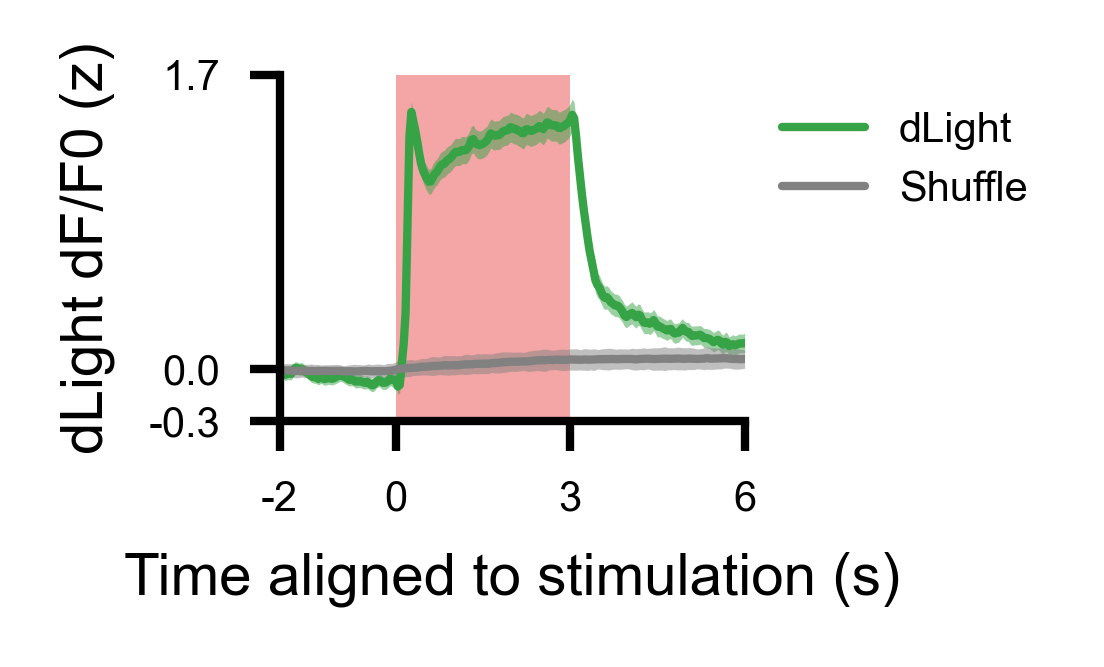

In [13]:
fig = fg(1, 0.75)
fig.dpi = 300
bootstrap_lineplot(
    boots.melt(value_name="dlight", var_name='time'),
    "time",
    "dlight",
    color=geno_palette.snc,
    linewidth=1,
    ci="sd",
    label="dLight",
)
ax = bootstrap_lineplot(
    shuffs.melt(value_name="dlight", var_name='time'),
    "time",
    "dlight",
    color=geno_palette.ctrl,
    linewidth=1,
    ci="sd",
    label="Shuffle",
)


clean_ticks(ax, axis="y", zero_symmetry=False, precision=1)
clean_ticks(ax, zero_symmetry=False, precision=1, dtype=int)
patch = Rectangle(
    (0, plt.ylim()[0]),
    3,
    plt.ylim()[1] - plt.ylim()[0],
    color="lightcoral",
    alpha=0.7,
    zorder=-5,
    linewidth=0,
)
ax.add_patch(patch)
plt.xlim(-2, 6)
plt.xticks([-2, 0, 3, 6], [-2, 0, 3, 6])
plt.xlabel("Time aligned to stimulation (s)")
plt.ylabel("dLight dF/F0 (z)")
sns.despine()
add_legend(ax)
saver(fig, "3-second-pulsed-stimulation-dlight-waveform");